In [1]:
import os
import pandas as pd
import numpy as np

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import pearsonr,spearmanr
import warnings
warnings.filterwarnings("ignore")#忽略警告

import datetime
from collections import Counter
from scipy import stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from calendar import day_abbr, month_abbr, mdays
import holidays
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2, mean_absolute_percentage_error as MAPE

In [2]:
df=pd.read_csv('./data/preprocessed/data.csv')

In [3]:
df['Date']=pd.to_datetime(df['Date'].astype('str'))

In [4]:
df.rename(columns={'Date':'ds','Price':'y'},inplace=True)

In [15]:
holidays_df = pd.DataFrame([], columns = ['ds','holiday'])
ldates = []
lnames = []
for date, name in sorted(holidays.Sweden(years=np.arange(2019, 2022 + 1)).items()):
    ldates.append(date)
    lnames.append(name)
    
ldates = np.array(ldates)
lnames = np.array(lnames)
holidays_df.loc[:,'ds'] = ldates
holidays_df.loc[:,'holiday'] = lnames
holidays_df.holiday.unique()

array(['Nyårsdagen', 'Trettondedag jul, Söndag', 'Söndag', 'Långfredagen',
       'Påskdagen, Söndag', 'Annandag påsk', 'Första maj',
       'Kristi himmelsfärdsdag', 'Sveriges nationaldag',
       'Pingstdagen, Söndag', 'Midsommarafton', 'Midsommardagen',
       'Alla helgons dag', 'Julafton', 'Juldagen', 'Annandag jul',
       'Nyårsafton', 'Trettondedag jul', 'Sveriges nationaldag, Söndag',
       'Annandag jul, Söndag', 'Första maj, Söndag', 'Juldagen, Söndag'],
      dtype=object)

### Autoregression

In [7]:
def train_test_split(data):
     
    train = data.set_index('ds').loc[:'2022-02-28', :].reset_index()
    test = data.set_index('ds').loc['2022-03-01':, :].reset_index()
    
    return train, test

In [24]:
def make_predictions_df(forecast, data_train, data_test): 
    """
    Function to convert the output Prophet dataframe to a datetime index and append the actual target values at the end
    """
    forecast.index = pd.to_datetime(forecast.ds)
    data_train.index = pd.to_datetime(data_train.ds)
    data_test.index = pd.to_datetime(data_test.ds)
    data = pd.concat([data_train, data_test], axis=0)
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

def plot_predictions(forecast, start_date):
    """
    Function to plot the predictions 
    """
    f, ax = plt.subplots(figsize=(14, 8))
    
    train = forecast.loc[start_date:'2022-02-28',:]
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = forecast.loc['2022-03-01':,:]
    ax.plot(test.index, test.y, 'ro', markersize=3)
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    ax.axvline(forecast.loc['2022-03-01', 'ds'], color='k', ls='--', alpha=0.7)

    ax.grid(ls=':', lw=0.5)
    
    return f, ax

In [90]:
def create_joint_plot(forecast, x='yhat', y='y', title=None): 

    g = sns.jointplot(x='yhat', y='y', data=forecast, kind="reg", color="b")
    g.fig.set_figwidth(8)
    g.fig.set_figheight(8)
    
    ax = g.fig.axes[1]
    if title is not None: 
        ax.set_title(title, fontsize=16)

    ax = g.fig.axes[0]
    ax.text(60, 80, "R = {:+4.2f}".format(forecast.loc[:,['y','yhat']].corr().iloc[0,1]), fontsize=16)
    ax.set_xlabel('Predictions', fontsize=15)
    ax.set_ylabel('Observations', fontsize=15)
    ax.set_xlim(0, 250)
    ax.set_ylim(0, 120)
    ax.grid(ls=':')
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

    ax.grid(ls=':')

In [641]:
df1=df.loc[:,['ds','y']]

In [642]:
train, test=train_test_split(df1)

In [643]:
train.head()

,ds,y
0,2019-01-01,22.58
1,2019-01-02,42.65
2,2019-01-03,51.90
3,2019-01-04,50.85
4,2019-01-05,50.72


In [645]:
m = Prophet(changepoint_prior_scale=0.0085,
            seasonality_mode='multiplicative',
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True)

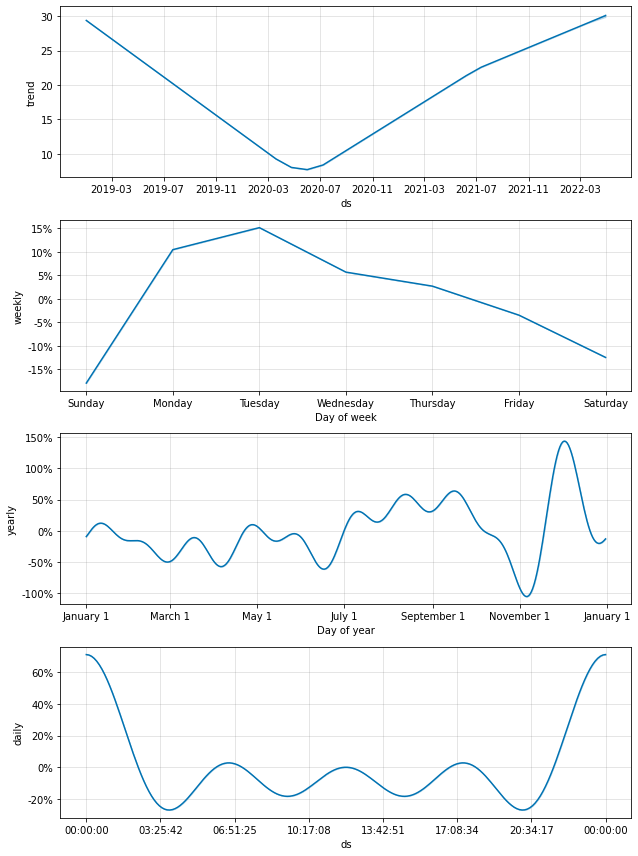

In [646]:
m.fit(train)

future = m.make_future_dataframe(periods=len(test), freq='1D')
forecast = m.predict(future)
f = m.plot_components(forecast)

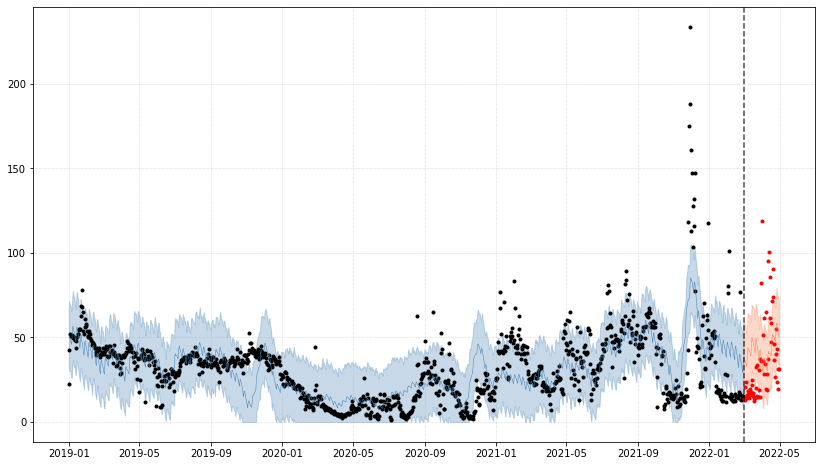

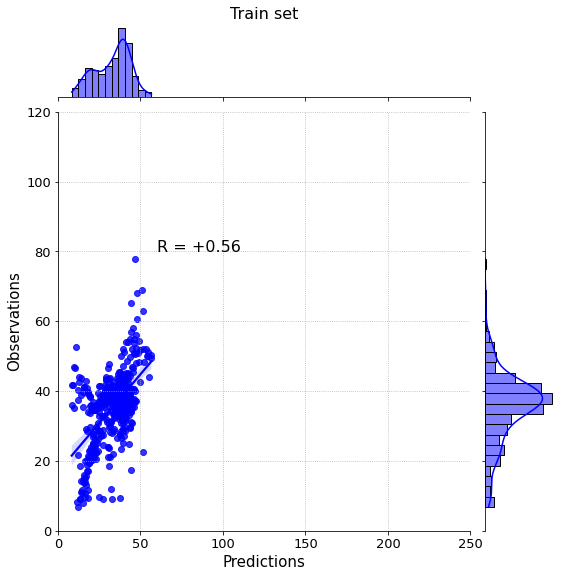

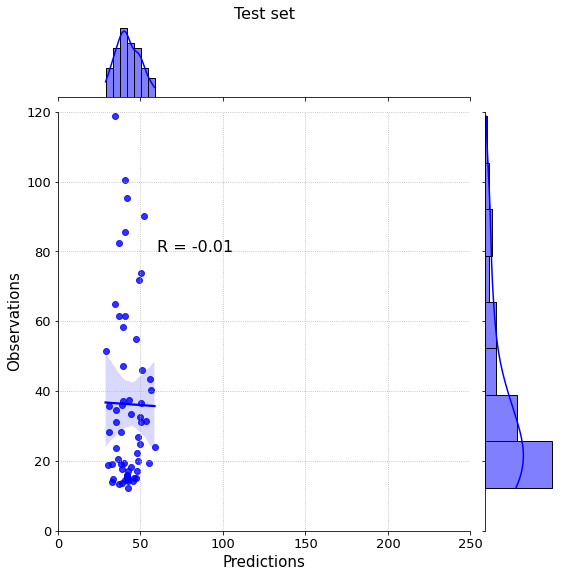

In [647]:
result = make_predictions_df(forecast, train, test)
result.loc[:,'yhat'] = result.yhat.clip(lower=0)
result.loc[:,'yhat_lower'] = result.yhat_lower.clip(lower=0)
result.loc[:, 'yhat_upper'] = result.yhat_upper.clip(lower=0)
f, ax = plot_predictions(result, '2019-01-01')
create_joint_plot(result.loc[:'2020-02-28', :], title='Train set')
create_joint_plot(result.loc['2022-03-01':, :], title='Test set')

In [661]:
result.loc[:,['y','yhat']]

,y,yhat
ds,,
2019-01-01,22.58,51.644197
2019-01-02,42.65,52.581704
2019-01-03,51.90,52.999481
2019-01-04,50.85,51.548907
2019-01-05,50.72,51.913101
...,...,...
2022-04-26,23.94,87.300795
2022-04-27,43.43,95.779421
2022-04-28,19.30,80.250345


In [664]:
type(result.yhat[1])

numpy.float64

In [648]:
# m.plot(forecast)

In [649]:
y_pred=result.loc['2022-03-01':,'yhat']
y_test=test.loc['2022-03-01':,'y']
print('MSE:%f, r2 score:%f and MAPE:%f \n' %(MSE(y_test,y_pred), R2(y_test,y_pred),MAPE(y_test,y_pred)))

MSE:728.764173, r2 score:-0.141036 and MAPE:0.893993 



### Model with extra-regressors

In [650]:
df

,ds,y,GDP,netimport,EV,EG,carbon,crude,gas,temp,precip,wind
0,2019-01-01,22.58,53292.187332,-21.671630,8.029611,165.879603,24.916938,53.553026,2.964937,3.9,1.113912,17.716219
1,2019-01-02,42.65,53293.963287,-21.708370,8.036170,165.900397,24.727155,54.910000,2.958000,-1.1,1.081985,17.802005
2,2019-01-03,51.90,53295.735821,-21.745108,8.042818,165.921191,24.488984,55.950001,2.945000,-2.7,1.050423,17.888769
3,2019-01-04,50.85,53297.504864,-21.781844,8.049554,165.941983,24.200305,57.060001,3.044000,2.7,1.019531,17.976465
4,2019-01-05,50.72,53299.270346,-21.818573,8.056381,165.962772,23.858996,57.708959,3.060007,0.8,0.989615,18.065043
...,...,...,...,...,...,...,...,...,...,...,...,...
1211,2022-04-26,23.94,53256.877019,-23.672716,17.801233,184.189287,83.430000,104.989998,6.850000,7.3,1.156897,21.354969
1212,2022-04-27,43.43,53252.699646,-23.660389,17.636705,184.239084,81.615707,105.320000,7.267000,4.9,1.168487,21.423244
1213,2022-04-28,19.30,53248.495739,-23.648040,17.471570,184.288904,80.550000,107.589996,6.888000,7.0,1.179634,21.488335
1214,2022-04-29,31.43,53244.265215,-23.635671,17.305825,184.338745,80.456200,109.339996,7.244000,6.0,1.190293,21.550000


In [651]:
train2, test2 = train_test_split(df)

In [652]:
m = Prophet(#holidays=holidays_df, 
            changepoint_prior_scale=0.007,
            seasonality_mode='multiplicative',
            yearly_seasonality=True, 
            weekly_seasonality=True,
            daily_seasonality=False)

In [653]:
# m.add_regressor('GDP')
# m.add_regressor('gas')
# m.add_regressor('crude')
# m.add_regressor('EG')
# m.add_regressor('wind')
# m.add_regressor('carbon')
# m.add_regressor('temp')
# m.add_regressor('netimport')
# m.add_regressor('precip')
# m.add_regressor('EV')

In [654]:
m.add_regressor('GDP', mode='multiplicative')
m.add_regressor('gas', mode='multiplicative')
m.add_regressor('crude', mode='multiplicative')
m.add_regressor('EG', mode='multiplicative')
m.add_regressor('wind', mode='multiplicative')
m.add_regressor('carbon', mode='multiplicative')
m.add_regressor('temp', mode='multiplicative')
m.add_regressor('netimport', mode='multiplicative')
m.add_regressor('precip', mode='multiplicative')
m.add_regressor('EV', mode='multiplicative')

# 'GDP','temp','netimport','precip']
# 'GDP','netimport','EV','EG','carbon','crude','gas','temp','precip','wind'

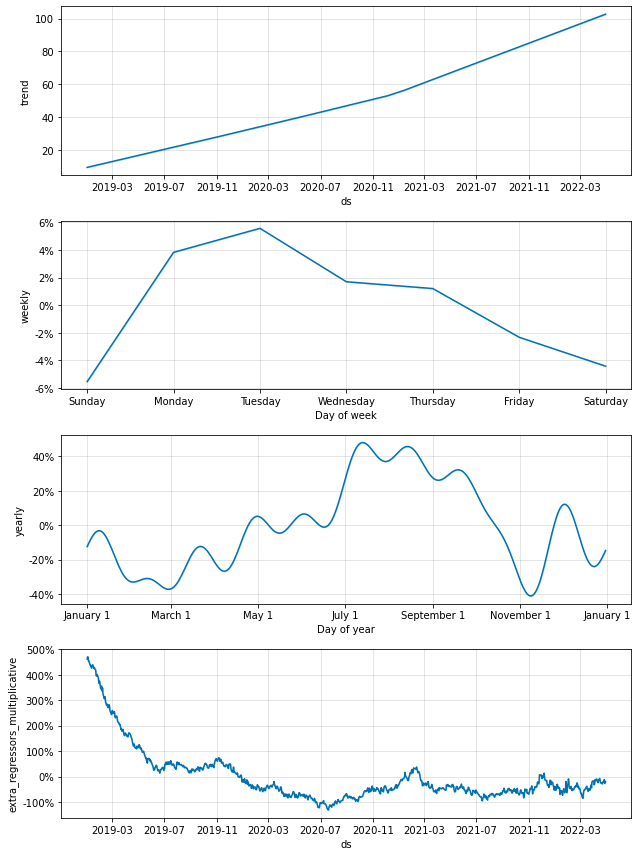

In [655]:
m.fit(train2)
future = m.make_future_dataframe(periods=len(test2), freq='1D')
futures = pd.concat([future, df.loc[:, ['GDP','netimport','EV','EG','carbon','crude','gas','temp','precip','wind']].reset_index(drop=True)], axis=1)

forecast = m.predict(futures)
f = m.plot_components(forecast)

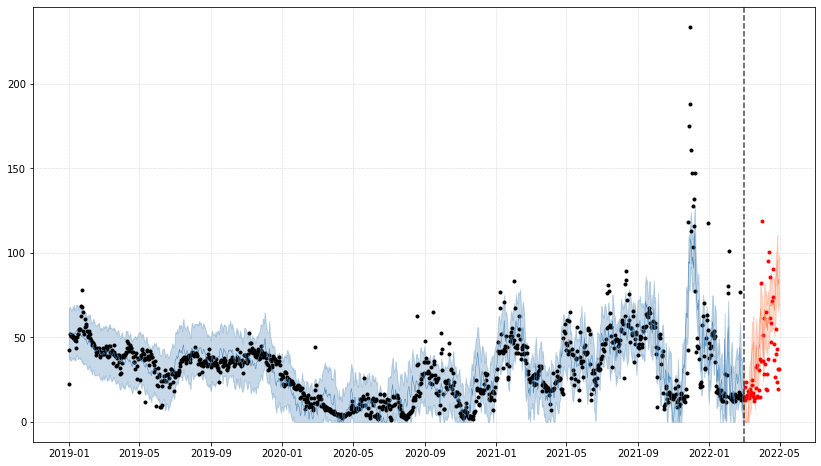

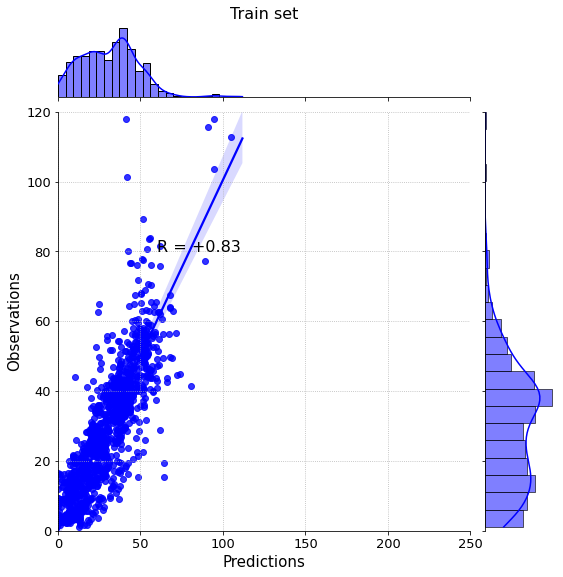

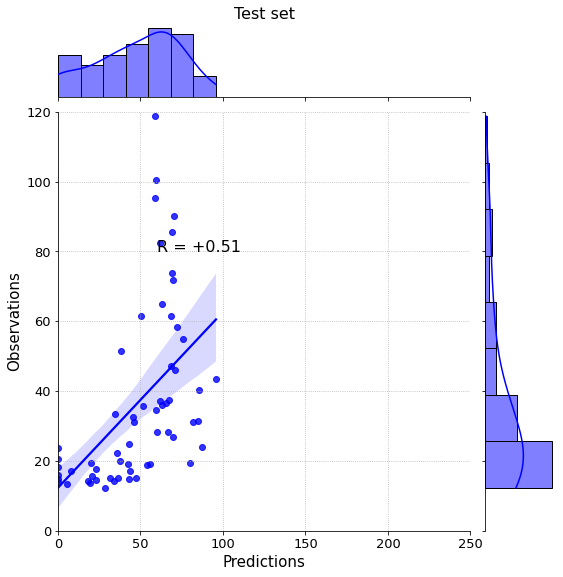

In [656]:
result = make_predictions_df(forecast, train2, test2)
result.loc[:,'yhat'] = result.yhat.clip(lower=0)
result.loc[:,'yhat_lower'] = result.yhat_lower.clip(lower=0)
result.loc[:, 'yhat_upper'] = result.yhat_upper.clip(lower=0)

f, ax = plot_predictions(result, '2019-01-01')

create_joint_plot(result.loc[:'2022-02-28', :], title='Train set')
create_joint_plot(result.loc['2022-03-01':, :], title='Test set')

In [657]:
y_pred=result.loc['2022-03-01':,'yhat']
y_test=test2.loc['2022-03-01':,'y']
print('MSE:%f, r2 score:%f and MAPE:%f \n' %(MSE(y_test,y_pred), R2(y_test,y_pred),MAPE(y_test,y_pred)))

MSE:762.733535, r2 score:-0.194222 and MAPE:0.852422 



In [658]:
result

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,EG,EG_lower,EG_upper,EV,...,wind_lower,wind_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2019-01-01,2019-01-01,9.312605,37.350361,66.645178,9.312605,9.312605,0.515197,0.515197,0.515197,0.963070,...,0.173313,0.173313,-0.132624,-0.132624,-0.132624,0.0,0.0,0.0,51.644197,22.58
2019-01-02,2019-01-02,9.373253,37.023882,67.876043,9.373253,9.373253,0.511031,0.511031,0.511031,0.962762,...,0.167050,0.167050,-0.114473,-0.114473,-0.114473,0.0,0.0,0.0,52.581704,42.65
2019-01-03,2019-01-03,9.433901,38.670025,68.166743,9.433901,9.433901,0.506865,0.506865,0.506865,0.962450,...,0.160716,0.160716,-0.097023,-0.097023,-0.097023,0.0,0.0,0.0,52.999481,51.90
2019-01-04,2019-01-04,9.494549,36.170184,67.066135,9.494549,9.494549,0.502700,0.502700,0.502700,0.962135,...,0.154313,0.154313,-0.080789,-0.080789,-0.080789,0.0,0.0,0.0,51.548907,50.85
2019-01-05,2019-01-05,9.555197,36.547340,65.975298,9.555197,9.555197,0.498535,0.498535,0.498535,0.961815,...,0.147846,0.147846,-0.066249,-0.066249,-0.066249,0.0,0.0,0.0,51.913101,50.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,2022-04-26,102.275351,72.771836,101.253178,102.187583,102.345351,-3.152959,-3.152959,-3.152959,0.504983,...,-0.092345,-0.092345,0.023471,0.023471,0.023471,0.0,0.0,0.0,87.300795,23.94
2022-04-27,2022-04-27,102.373614,80.873099,110.660917,102.281756,102.446635,-3.162936,-3.162936,-3.162936,0.512696,...,-0.097330,-0.097330,0.034390,0.034390,0.034390,0.0,0.0,0.0,95.779421,43.43
2022-04-28,2022-04-28,102.471878,65.001654,94.717766,102.377903,102.547145,-3.172917,-3.172917,-3.172917,0.520438,...,-0.102082,-0.102082,0.042739,0.042739,0.042739,0.0,0.0,0.0,80.250345,19.30
